# Building a CORD19 Research Engine

In this notebook we build a **CORD Research Engine** on top of a **BM25** search index, along with a full document **Similarity Index** by storing the 786 dimension **Specter Vectors** in an **Annoy** index. Both these indexes complement each other - **BM25** is unmatched for search while the Specter Vectors provide unprecedented accuracy in similarity matching.

These indexes are complemented an intuitive user interface - both with an **interactive Search Bar** as well as a natural language like Python API `papers.similar_to`, all running within a notebook. The combination of these features pushes the boundary of what can be achieved in notebooks in terms of speed of information retrieval, assembly and publication. This is shown in the <a href="#Task-Notebooks">9 task specific notebooks</a> created with the help of the CORD Research Engine.

Of course the entire point to to provide insights into how to fight the SARS-COV2 pandemic, and we prioritize the surfacing of actionable research in this main notebook and in the task specific notebooks. The code for the engine is also available on github as will be explained below.

In [1]:
from ipywidgets import Image
f = open("../input/cord-images/cord_research.png", "rb")
image = f.read()
Image(value=image)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01h\x08\x03\x00\x00\x00\xf0\xec\xba…

### Clustering

In [2]:
f = open("../input/cord-images/paper_clusters.png", "rb")
image = f.read()
Image(value=image)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xd0\x00\x00\x02\x02\x08\x06\x00\x00\x00\xe6\xa1\…

### 2D Visual Search

In [3]:
f = open("../input/cord-images/search2d.png", "rb")
image = f.read()
Image(value=image)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x01s\x08\x06\x00\x00\x00\xae#\xb8\t\…

### Interactive Searchbar

In [4]:
f = open("../input/cord-images/advancedsearch.png", "rb")
image = f.read()
Image(value=image)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\xbc\x00\x00\x01\x9e\x08\x06\x00\x00\x00v6\xd2\xe…

# Task Notebooks

This notebook is used as the base for the following Task notebooks

<a href="https://www.kaggle.com/dgunning/current-research-on-diagnostics-and-surveillance" target="_blank">What do we know about Diagnostics and Surveillance</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-vaccines-and-therapeutics" target="_blank">What do we know about Vaccines and Therapeutics</a>

<a href="https://www.kaggle.com/dgunning/current-research-nonpharmaceutical-interventions" target="_blank">hat do we know about NonPharmaceutical Interventions</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-social-and-ethical-concerns" target="_blank">What do we know about Social and Ethical Concerns</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-genetics-origin-and-evolution" target="_blank">What do we know about Genetic Origin and Evolution</a>

<a href="https://www.kaggle.com/dgunning/cord-research-on-information-sharing" target="_blank">What do we know about Information Sharing</a>

<a href="https://www.kaggle.com/dgunning/transmission-incubation-and-environment-stability" target="_blank">What do we know about Transmission Incubation and Environment Stability</a>

<a href="https://www.kaggle.com/dgunning/what-we-know-about-medical-care" target="_blank">What do we know about Medical Care</a>

## Table of Contents

<a href="#1.--Installing-the-dgunning/cord19-Library">1. Installing the cord library</a>

<a href="#2.--Loading-Research-Papers">2. Loading Research Papers</a>

<a href="#3.-Searching-Research-Papers">3. Searching Research Papers</a>

&nbsp;&nbsp;<a href="#With-the-search-function">  With the search function</a>

&nbsp;&nbsp;<a href="#With-the-searchbar">  With the searchbar</a>

<a href="#4.-Selecting-Research-Papers">4. Selecting Research Papers</a>

<a href="#5.-Selecting-Individual-Papers">5. Selecting Individual Papers</a>

<a href="#6.-Exploratory-Analysis-and-Charts">6. Exploratory Analysis and Charts</a>

<a href="#7.-Technical-Notes">7. Technical Notes</a>

&nbsp;&nbsp;<a href="#What-is-BM25">  What is BM25</a>

&nbsp;&nbsp;<a href="#Preprocessing-Text">  Preprocessing Text</a>

&nbsp;&nbsp;<a href="#Loading-JSON">  Loading JSON</a>

&nbsp;&nbsp;<a href="#Parallel-Processing-Code">  Parallel Processing Code</a>





# 1.  Installing the dgunning/cord19 Library

The code for this kernel is maintained at https://github.com/dgunning/cord19. To install it in the Kaggle kernel, the Internet must be set to ON.

In [5]:
!pip install -U git+https://github.com/dgunning/cord19.git

  Cloning https://github.com/dgunning/cord19.git to /tmp/pip-req-build-pq_1od61
  Running command git clone -q https://github.com/dgunning/cord19.git /tmp/pip-req-build-pq_1od61
     |████████████████████████████████| 152 kB 6.7 MB/s 
     |████████████████████████████████| 914 kB 17.1 MB/s 
     |████████████████████████████████| 489 kB 40.2 MB/s 
  Created wheel for cord19: filename=cord19-0.4.0-py3-none-any.whl size=36264374 sha256=3246a398cf944811a56cee31b4af72f0a1f63fe29d55c3887294f1e7e42febd4
  Stored in directory: /tmp/pip-ephem-wheel-cache-po9cdce0/wheels/b5/5f/c9/e8f1f0ffb84f0824610ea8137bb5492ccde4a8d4b794119c2d
  Created wheel for rank-bm25: filename=rank_bm25-0.2-py3-none-any.whl size=4161 sha256=735cba71c7eb9189703ee81df3beb15cea24de6d5ded956938e68bc953c365c4
  Stored in directory: /root/.cache/pip/wheels/82/a9/a2/33d3c389435f63f6fa490ef91417c997ccc4e7db75f5a7b2f8
Successfully built cord19 rank-bm25
ERROR: spyder 3.3.6 requires pyqt5<5.13; python_version >= "3", which is n

# Technical Design Notes
For current details on the design of the **cord** library, check the project on [github/dgunning/cord19](https://github.com/dgunning/cord19)

The **ResearchPapers** class is a container for the metadata, and the BM25 search index. It contains functions to find papers using **index** `research_papers[0]`,  **cord_uid** `research_papers["4nmc356g"]`, **OR** to create subsets of ResearchPapers like `papers.since_sarscov2`, **OR** to run `search()` or display the `searchbar()`

Because the ResearchPapers class is simply a container for the metadata dataframe, and all useful information about each paper is on the dataframe as a column, including the **index_tokens**, tags such as **covid_related** etc, subsetting ResearchPapers is simply a matter of subsetting the **metadata** dataframe, then creating a new ResearchPapers instance. To create a ResearchPapers instance after a date means 
```{python}
    def after(self, date, include_null_dates=False):
        cond = self.metadata.published >= date
        if include_null_dates:
            cond = cond | self.metadata.published.isnull()
        return self._make_copy(self.metadata[cond])
```
Thus, we implement functions such as **head**, **tail**, **sample**, **query**, which just delegate to the metadata dataframe function and then create a new ResearchPapers instance.

## What happens in ResearchPapers.load?
1. **load_metadata** - Load the **metadata.csv** file
```{python}
@staticmethod
    def load_metadata(data_path=None):
        if not data_path:
            data_path = find_data_dir()

        print('Loading metadata from', data_path)
        metadata_path = PurePath(data_path) / 'metadata.csv'
        dtypes = {'Microsoft Academic Paper ID': 'str', 'pubmed_id': str}
        renames = {'source_x': 'source', 'has_full_text': 'has_text'}
        metadata = pd.read_csv(metadata_path, dtype=dtypes, low_memory=False,
                               parse_dates=['publish_time']).rename(columns=renames)
```
2. **clean_metadata** - Clean the metadata
```{python}
def clean_metadata(metadata):
    print('Cleaning metadata')
    return metadata.pipe(start) \
        .pipe(clean_title) \
        .pipe(clean_abstract) \
        .pipe(rename_publish_time) \
        .pipe(add_date_diff) \
        .pipe(drop_missing) \
        .pipe(fill_nulls) \
        .pipe(apply_tags)
```

3. **Create the BM25 Search Index**

**ResearchPapers** can be indexed with the metadata *abstracts* OR with the *text* content of the paper. Indexing from the abstracts is straightforward - we just apply a **preprocess** function to clean and tokenize the abstract. Indexing from the texts - if no json-cache exists - happens by loading the JSON files and, tokenizing the texts and setting the **index_tokens** on the metadata. However, there is now a **json_cache** dataset comprised of the preprocessed text tokens, along with the JSOn file's sha - which we use to merge into the metadata.

After the metadata is loaded and cleaned we create the **BM25** index inside of **ResearchPapers.__init__()**

```{python}
      
if 'index_tokens' not in metadata:
    print('\nIndexing research papers')
    if any([index == t for t in ['text', 'texts', 'content', 'contents']]):
        _set_index_from_text(self.metadata, data_dir)
    else:
        print('Creating the BM25 index from the abstracts of the papers')
        print('Use index="text" if you want to index the texts of the paper instead')
        tick = time.time()
        self.metadata['index_tokens'] = metadata.abstract.apply(preprocess)
        tock = time.time()
        print('Finished Indexing in', round(tock - tick, 0), 'seconds')

```

## Creating Document Vectors
Creating document vectors is simple. First we load the cached JSON tokens. (This is a cached version of the JSON files optimized for memory and disk space)
```
json_tokens = []
for catalog in JSON_CATALOGS:
    json_cache = load_json_cache(catalog)
    json_tokens.append(json_cache)
    
json_tokens = pd.concat(json_tokens, ignore_index=True)
```

then we train a **gensim Doc2Vec** model to create vectors with length **VECTOR_SIZE** (currently 20)

```
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(json_tokens.index_tokens)]
model = Doc2Vec(documents, vector_size=VECTOR_SIZE, window=2, min_count=1, workers=8)
```
Next we can create a document vector for each json record
```
json_tokens['document_vector'] = json_tokens.index_tokens.apply(model.infer_vector)
```

### Document Similarity Index
The document similarity index is based on [Annoy](https://github.com/spotify/annoy). Annoy is very simple and super fast, and will return the mst similar items to a given query.

```
from annoy import AnnoyIndex

annoy_index = AnnoyIndex(DOCUMENT_VECTOR_LENGTH, 'angular')  
for i in range(len(metadata)):
    v = json_tokens.loc[i].document_vector
    annoy_index.add_item(i, v)

annoy_index.build(10) # 10 trees
```

# 2. Loading Research Papers

In [6]:
from cord import ResearchPapers

research_papers = ResearchPapers.load()

Loading metadata from ../input/CORD-19-research-challenge
Cleaning metadata
Applying tags to metadata

Indexing research papers
Creating the BM25 index from the abstracts of the papers
Use index="text" if you want to index the texts of the paper instead
Finished Indexing in 116.0 seconds


# 3. Searching Research Papers

The ResearchPapers instance provides two main ways of searching - using the function **search()** or using the function **searchbar()** which will show an interactive search bar. 





### With the search function

The ResearchPapers class has a function **search** in which you can specify search terms. The function will use the **BM25** index to retrieve the documents that most closely satisfy the search

In [7]:
research_papers.search('antiviral treatment')

### With the searchbar
You can call searchbar() without any arguments to show the widget without any initial search results, or with an initial search string, which we will do below.

In [8]:
research_papers.searchbar('antiviral treatment')

# 4. Selecting Research Papers

There are many ways to select subsets of research papers including

- **Papers since SARS**  `research_papers.since_sars()`
- **Papers since SARS-COV-2** `research_papers.since_sarscov2()`
- **Papers before SARS** `research_papers.before_sars()`
- **Papers before SARS-COV-2** `research_papers.before_sarscov2()`
- **Papers before a date** `research_papers.before('1989-09-12')`
- **Papers after a date** `research_papers.after('1989-09-12')`
- **Papers that contains a string** 
- **Papers that match a string (using regex)** 

Here we are interested in research papers since the sars-cov-2 outbreak

### Research papers since SARS-COV-2

In [9]:
since_covid = research_papers.since_sarscov2()
since_covid

### Research Papers that match the H{num}N{num} pattern
The code below returns papers that match the regex "H[0-9]N[0-9]"

In [10]:
research_papers.match('H[0-9]N[0-9]')

### Match string columns
To select research papers that match on a string column, use `research_papers.match(<searchstring>)`. If no column is specified, then the abstract is used.

The following shows what has been published by **Anthony Fauci** since the SARS-COV-2 outbreak

In [11]:
research_papers.contains("Fauci", column='authors').since_sarscov2()

# 5. Selecting Individual Papers
Individual papers can be selected from the ResearchPapers instance using the **[]** selectors, using the index number of the paper. Note that you will likely never know the index value of the paper that you need, but this ability will come in handy when using the search tool.

### Selecting a paper by index
You can select any paper in the **ResearchPapers** instance using the index. This will locate and create a new **Paper** instance, which you can output to the notebook.

In [12]:
paper = research_papers[197]
paper

,published,authors,cord_uid,url
,2006-04-04,"Martin, Greg",5rfgyiit,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...


### Selecting a paper by cord_uid
You can also select a paper using its **cord_uid**.

In [13]:
paper = research_papers['asf5c7xu'] # or research_papers['5c31897d01f3edc7f58a0f03fceec2373fcfdc3d']
paper

,published,authors,cord_uid,url
,2010-10-31,"Jenny, Shireen L.; Hu, Yaobi; Overduin, Pieter...",asf5c7xu,https://doi.org/10.1016/j.jcv.2010.07.005


This would be similar to querying research_papers for a single sha, but in this case a **ResearchPapers** instance is returned.

In [14]:
research_papers.query("sha=='5c31897d01f3edc7f58a0f03fceec2373fcfdc3d'")

### Viewing a Research Paper
Once you have a research paper, there are many ways to view it.

- **Overview** A nicely formatted view of the paper's important fields
- **Abstract** The paper's abstract
- **Summary** A summary of the paper's abstract using the **TextRank** algorithm
- **Text** The text the paper
- **HTML** The contents of the paper as somewhat nicely formatted HTML
- **Text Summary** The text of the paper, summarized using the **TextRank** algorithm

In [15]:
from ipywidgets import interact
from IPython.display import display

paper = research_papers['asf5c7xu']

def view_paper(ViewPaperAs):
    if ViewPaperAs == 'Overview':
        display(paper)
    elif ViewPaperAs == 'Abstract':
        display(paper.abstract)
    elif ViewPaperAs == 'Summary of Abstract':
        display(paper.summary)
    elif ViewPaperAs == 'HTML':
        display(paper.html)
    elif ViewPaperAs == 'Text':
        display(paper.text)
    elif ViewPaperAs == 'Summary of Text':
        display(paper.text_summary)
    
interact(view_paper,
         ViewPaperAs=['Overview', # Show an overview of the paper's important fields and statistics
                      'Abstract', # Show the paper's abstract
                      'Summary of Abstract', # Show a summary of the paper's abstract
                      'HTML', # Show the paper's contents as (slightly) formatted HTML
                      'Text', # Show the paper's contents
                      'Summary of Text' # Show a summary of the paper's content
                     ]
        );

,published,authors,cord_uid,url
,2010-10-31,"Jenny, Shireen L.; Hu, Yaobi; Overduin, Pieter...",asf5c7xu,https://doi.org/10.1016/j.jcv.2010.07.005


### Finding Similar Papers

In [16]:
research_papers.similar_to('asf5c7xu')

HTML(value='<h4>Papers similar to <span style="color: #008B8B; font-weight: bold; font-size: 0.9em;">Evaluatio…

title,summary,when,cord_uid
Evaluation of Seegene Allplex Respiratory Panel 1 kit for the detection of influenza virus and human respiratory syncytial virus,"Seegene’s Allplex™ Respiratory Panel 1 (Allplex RP1) is a real-time one-step RT-PCR assay for the simultaneous detection of FLUAV, FLUBV, HRSV-A and HRSV-B. Objectives This study aims to evaluate Allplex RP1 as a rapid molecular test for the detection of FLUAV, FLUBV, HRSV-A and HRSV-B viruses. Results Allplex RP1, ProFlu+ and GeneXpert tests showed 95%, 91% and 96% of accuracy; and 94%, 88% and 95% of sensitivity, respectively. The three assays showed a 100% of specificity and PPV, while the NPV were 84%, 73% and 86% for Allplex RP1, Prodesse and GeneXpert, respectively. Conclusions In this study, Seegene’s Allplex RP1 assay showed to be highly sensitive, specific, and suitable for detection of FLUV and HRSV, including FLUAV subtyping.",2 years ago,3fc8utbl
Evaluation of Commercial Diagnostic Assays for the Specific Detection of Avian Influenza A (H7N9) Virus RNA Using a Quality-Control Panel and Clinical Specimens in China,"A novel avian influenza A H7N9-subtype virus emerged in China in 2013 and threatened global public health. The safety and effectiveness of three commercial molecular diagnostic assays were evaluated using a quality-control panel and clinical specimens collected from over 90 patients with confirmed avian influenza A (H7N9) virus infections. The detection limit of all the commercial assays was 2.83 Log(10) copies/μl [0.7 Log(10)TCID(50)/mL of avian influenza A (H7N9) virus strain A/Zhejiang/DTID-ZJU01/2013], which is comparable to the method recommended by the World Health Organization (WHO). In conclusion, our findings provide comprehensive evidence for the high performance of three commercial diagnostic assays and suggest the application of these assays as rapid and effective diagnostic tools for avian influenza A (H7N9) virus in the routine clinical practice of medical laboratories.",5 years ago,hhyvbvgf
Field evaluation of TaqMan Array Card (TAC) for the simultaneous detection of multiple respiratory viruses in children with acute respiratory infection,"A previous study described the development of TAC for the detection of respiratory viral and bacterial pathogens; the assay was evaluated against well-characterized analytical materials and a limited collection of human clinical specimens. Objectives We wished to compare TAC assay performance against standard individual RT-qPCR assays for respiratory viral detection, focusing on 10 viruses (adenovirus, human metapneumovirus, human parainfluenza viruses 1–4, influenza viruses A and B, respiratory syncytial virus, and rhinovirus) from a larger collection of human specimens. Results Compared with standard individual RT-qPCR assays, the sensitivity of TAC for the targeted viruses ranged from 54% to 95% (54%, 56%, and 75% for adenovirus, human parainfluenza viruses-1 and -2, respectively, and 82%–95% for the other viruses).",7 years ago,k621d8w9
Design and Performance of the CDC Real-Time Reverse Transcriptase PCR Swine Flu Panel for Detection of 2009 A (H1N1) Pandemic Influenza Virus,"These procedures were utilized in April 2009 for detection of human cases of 2009 A (H1N1) pandemic (pdm) influenza virus infection. Based on genetic sequence data derived from the first two viruses investigated, the previously developed rRT-PCR procedures were optimized to create the CDC rRT-PCR Swine Flu Panel for detection of the 2009 A (H1N1) pdm influenza virus. The analytical sensitivity of the CDC rRT-PCR Swine Flu Panel was shown to be 5 copies of RNA per reaction and 10(−1.3∼−0.7) 50% infectious doses (ID(50)) per reaction for cultured viruses. The CDC rRT-PCR Swine Flu Panel served as an effective tool for timely and specific detection of 2009 A (H1N1) pdm influenza viruses and facilitated subsequent public health response implementation.",9 years ago,btefyqvw
Evaluation of Twelve Real-Time Reverse Transcriptase 

### Widgets in Jupyter notebook
The code above also show how to use **ipywidgets interact** and **IPython display** to provide a userinterface inside a Jupyter notebook. 

# 6. Exploratory Analysis and Charts

### Load Document Vectors

Each research paper's content was converted to a document vector using **gensim's Doc2Vec**. We load the document vectors and filter out any empty vectors. (We have some empty vectors where the research paper was not associated with any JSON content)

In [17]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from cord.core import cord_support_dir

# Load the document vectors
vectors = pd.read_parquet(cord_support_dir()/ 'DocumentVectors.pq').reset_index()
display(widgets.HTML('<h4>Document Vectors</h4>'))
display(vectors.head())

# Use the metadata of the research_papers
metadata = research_papers.metadata.copy()

vector_metadata_merge = vectors.merge(metadata, on='cord_uid', how='right')
vectors['covid_related'] = vector_metadata_merge.covid_related
vectors['published'] = vector_metadata_merge.published
display(widgets.HTML('<h4>Document Vectors with covid_related and published</h4>'))
display(vectors.head())

HTML(value='<h4>Document Vectors</h4>')

,cord_uid,cluster,x,y,1d,2d
0,xqhn0vbp,0,-16.746437,13.216263,-16.746437,"[-16.74643680817409, 13.216263026643853]"
1,gi6uaa83,0,1.966327,-2.207469,1.966327,"[1.9663268777746572, -2.2074688325530283]"
2,le0ogx1s,6,31.708845,8.587331,31.708845,"[31.708844578373675, 8.587330999326701]"
3,fy4w7xz8,3,-15.848964,16.420672,-15.848964,"[-15.848964066106522, 16.420671871807553]"
4,0qaoam29,0,-11.824390,16.038072,-11.824390,"[-11.824389780999928, 16.038071989756528]"


HTML(value='<h4>Document Vectors with covid_related and published</h4>')

,cord_uid,cluster,x,y,1d,2d,covid_related,published
0,xqhn0vbp,0,-16.746437,13.216263,-16.746437,"[-16.74643680817409, 13.216263026643853]",False,2003-01-13
1,gi6uaa83,0,1.966327,-2.207469,1.966327,"[1.9663268777746572, -2.2074688325530283]",False,2003-04-28
2,le0ogx1s,6,31.708845,8.587331,31.708845,"[31.708844578373675, 8.587330999326701]",False,2003-06-27
3,fy4w7xz8,3,-15.848964,16.420672,-15.848964,"[-15.848964066106522, 16.420671871807553]",False,2003-09-12
4,0qaoam29,0,-11.824390,16.038072,-11.824390,"[-11.824389780999928, 16.038071989756528]",False,2003-09-10


### Chart showing clusters of research papers
The chart below shows the research papers in 2D space. The chart below is done in **Altair** - the best Python charting library.

In [18]:
import altair as alt


vector_df = pd.DataFrame({'x':vectors.x,
                          'y': vectors.y,
                          '1d': vectors['1d'],
                          'cluster': vectors.cluster,
                          'covid_related': vectors.covid_related,
                          'published': vectors.published})  # Ensure 5000 limit

alt.Chart(vector_df.sample(5000)).mark_point().encode(
       x=alt.X('x', axis=None),
       y=alt.Y('y', axis=None),
       color= 'cluster:N'
    ).properties(
        title='CORD Research Papers in 2D space',
        width=600,
        height=400
    ).configure_axis(
        grid=False
    ).configure_view(
        strokeWidth=0
    )

alt.Chart(...)

### Identify which clusters are covid related

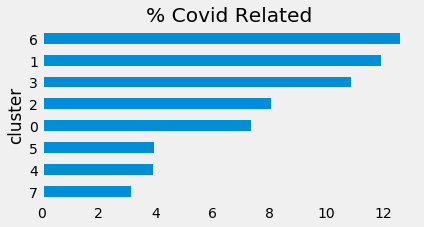

In [19]:
import matplotlib.style as style
style.use('fivethirtyeight')
covid_count = vector_df[['cluster', 'covid_related']].groupby(['cluster']).sum() 
cluster_count = vector_df[['cluster', 'covid_related']].groupby(['cluster']).count() 
covid_cluster_stats = (covid_count / cluster_count) * 100
covid_cluster_stats = covid_cluster_stats.sort_values(['covid_related'])
fig = covid_cluster_stats.plot.barh(grid=False, figsize=(6, 3), legend=False, title='% Covid Related');

### Research Papers since COVID

We plot the 1d compression of the 768-dimension document vector over time, with the clusters identified by color. Then we plot clusters 2 and 6. We see a big increase in the number of papers since COVID appeared

In [20]:
vector_since = vector_df.query('published > "2015-01-01" & (cluster==2 | cluster==6)').copy()
vector_since.loc[vector_since.published> '2020-06-30', 'published'] = pd.to_datetime('2020-03-30')
if len(vector_since) > 5000:
    vector_since = vector_since.sample(5000)
alt.Chart(vector_since).mark_point().encode(
       x=alt.X('published:T'),
       y=alt.Y('1d'),
       color= 'cluster:N'
    ).properties(
        title='CORD Research Papers since 2015',
        width=600,
        height=400
    ).configure_axis(
        grid=False
    ).configure_view(
        strokeWidth=0
    )

alt.Chart(...)

### New Feature - 2D Visual Search

In [21]:
query ="""
Efforts to identify the underlying drivers of fear, anxiety and stigma that
fuel misinformation and rumor, particularly through social media.
"""
research_papers.search_2d(query)

HTML(value='<h4>\nEfforts to identify the underlying drivers of fear, anxiety and stigma that\nfuel misinforma…

alt.Chart(...)

# 7. Technical Notes
What follows here will be a discussion of the technical design of the CORD library with code snippets

## What is BM25

**BM25** stands for **Best Match the 25th iteration** and is a text search algorithm first developed in 1994. It is one of the best search algorithms available, and **Lucene**, and its derivatives **Solr** and **ElasticSearch** switched to a **BM25** variant around 2015.

### Creating a simple BM25 index
To show how to create a BM25 index, we will first load the metadata, and just use a subset of the columns and the rows

In [22]:
import pandas as pd
import numpy as np
from rank_bm25 import BM25Okapi
pd.options.display.max_colwidth=160

meta_df = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv') # Or pd.read_csv()
meta_df = meta_df[['title', 'abstract', 'publish_time']].head(1000)
meta_df

,title,abstract,publish_time
0,Airborne rhinovirus detection and effect of ultraviolet irradiation on detection by a semi-nested RT-PCR assay,"BACKGROUND: Rhinovirus, the most common cause of upper respiratory tract infections, has been implicated in asthma exacerbations and possibly asthma deaths....",2003-01-13
1,Discovering human history from stomach bacteria,Recent analyses of human pathogens have revealed that their evolutionary histories are congruent with the hypothesized pattern of ancient and modern human p...,2003-04-28
2,A new recruit for the army of the men of death,"The army of the men of death, in John Bunyan's memorable phrase, has a new recruit, and fear has a new face: a face wearing a surgical mask.",2003-06-27
3,Association of HLA class I with severe acute respiratory syndrome coronavirus infection,BACKGROUND: The human leukocyte antigen (HLA) system is widely used as a strategy in the search for the etiology of infectious diseases and autoimmune disor...,2003-09-12
4,A double epidemic model for the SARS propagation,BACKGROUND: An epidemic of a Severe Acute Respiratory Syndrome (SARS) caused by a new coronavirus has spread from the Guangdong province to the rest of Chin...,2003-09-10
...,...,...,...
995,The Feasibility of Canine Rabies Elimination in Africa: Dispelling Doubts with Data,"BACKGROUND: Canine rabies causes many thousands of human deaths every year in Africa, and continues to increase throughout much of the continent. METHODOLOG...",2010-02-23
996,Escape from Human Monoclonal Antibody Neutralization Affects In Vitro and In Vivo Fitness of Severe Acute Respiratory Syndrome Coronavirus,BACKGROUND: Severe Acute Respiratory Syndrome (SARS) emerged as a human disease in 2002 and detailed phylogenetic analysis and epidemiological studies have ...,2010-03-15
997,The Diagnosis of Viral Respiratory Disease in Older Adults,"Viral respiratory disease in older adults has been increasingly recognized as a significant cause of hospitalizations and death. Unfortunately, the recognit...",2010-02-01
998,Human Noroviruses in Swine and Cattle,Human noroviruses are the predominant cause of foodborne gastroenteritis worldwide. Strains of norovirus also exist that are uniquely associated with animal...,2007-08-10


### Preprocessing Text
To create the index, we need a list of the tokens in each string. The easiest way to do so is by using **gensim** or **NLTK** to tokenize each abstract into a list of tokens. Here we use **gensim**

In [23]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents, preprocess_string

meta_df_tokens = meta_df.abstract.fillna('').apply(preprocess_string)

Now we create a **BM25Okapi** index from the tokens. We also implement a search function that returns the top 10 results from the search.
Note that in search wer are asking the index to return the dataframe indexes of the tokens most similar to the search string.

In [24]:
from rank_bm25 import BM25Okapi
import numpy as np

bm25_index = BM25Okapi(meta_df_tokens.tolist())

def search(search_string, num_results=10):
    search_tokens = preprocess_string(search_string)
    scores = bm25_index.get_scores(search_tokens)
    top_indexes = np.argsort(scores)[::-1][:num_results]
    return top_indexes

indexes = search('novel coronavirus treatment')
indexes

array([820, 391,   7, 234, 918, 374, 837,  44, 213,  19])

You can use the indexes to locate the rows in **meta_df** which best match the search terms

In [25]:
meta_df.loc[indexes, ['abstract', 'publish_time']]

,abstract,publish_time
820,BACKGROUND: Destruction of the architectural and subsequently the functional integrity of the lung following pulmonary viral infections is attributable to b...,2009-09-23
391,"The recent SARS epidemic has boosted interest in the discovery of novel human and animal coronaviruses. By July 2007, more than 3000 coronavirus sequence re...",2007-10-02
7,"Because of the constant threat posed by emerging infectious diseases and the limitations of existing approaches used to identify new pathogens, there is a g...",2003-11-17
234,"The N-terminal domain of the coronavirus nucleocapsid (N) protein adopts a fold resembling a right hand with a flexible, positively charged β-hairpin and a ...",2006-09-13
918,"BACKGROUND: On June 11, 2009, the World Health Organization declared phase 6 of the novel influenza A/H1N1 pandemic. Although by the end of September 2009, ...",2009-12-21
374,"In response to viral infection, the expression of numerous host genes, including predominantly a number of proinflammatory cytokines and chemokines, is usua...",2008-01-30
837,"Severe acute respiratory syndrome (SARS) is a newly emerging infectious disease caused by a novel coronavirus, SARS-coronavirus (SARS-CoV). The SARS-CoV spi...",2009-02-09
44,"BACKGROUND: Severe acute respiratory syndrome (SARS) emerged in later February 2003, as a new epidemic form of life-threatening infection caused by a novel ...",2005-01-18
213,"BACKGROUND: Despite recent successes with biological agents as therapy for autoimmune inflammatory diseases such as rheumatoid arthritis (RA), many patients...",2006-09-12
19,"BACKGROUND: Despite the passing of more than a year since the first outbreak of Severe Acute Respiratory Syndrome (SARS), efficient counter-measures are sti...",2004-06-06


Or use the search function directly in **meta_df.loc[]**

In [26]:
meta_df.loc[search('novel coronavirus treatment')]

,title,abstract,publish_time
820,Inducible Bronchus-Associated Lymphoid Tissue Elicited by a Protein Cage Nanoparticle Enhances Protection in Mice against Diverse Respiratory Viruses,BACKGROUND: Destruction of the architectural and subsequently the functional integrity of the lung following pulmonary viral infections is attributable to b...,2009-09-23
391,CoVDB: a comprehensive database for comparative analysis of coronavirus genes and genomes,"The recent SARS epidemic has boosted interest in the discovery of novel human and animal coronaviruses. By July 2007, more than 3000 coronavirus sequence re...",2007-10-02
7,Viral Discovery and Sequence Recovery Using DNA Microarrays,"Because of the constant threat posed by emerging infectious diseases and the limitations of existing approaches used to identify new pathogens, there is a g...",2003-11-17
234,Amino acid residues critical for RNA-binding in the N-terminal domain of the nucleocapsid protein are essential determinants for the infectivity of coronavi...,"The N-terminal domain of the coronavirus nucleocapsid (N) protein adopts a fold resembling a right hand with a flexible, positively charged β-hairpin and a ...",2006-09-13
918,Breaking the Waves: Modelling the Potential Impact of Public Health Measures to Defer the Epidemic Peak of Novel Influenza A/H1N1,"BACKGROUND: On June 11, 2009, the World Health Organization declared phase 6 of the novel influenza A/H1N1 pandemic. Although by the end of September 2009, ...",2009-12-21
374,Coronavirus Spike Protein Inhibits Host Cell Translation by Interaction with eIF3f,"In response to viral infection, the expression of numerous host genes, including predominantly a number of proinflammatory cytokines and chemokines, is usua...",2008-01-30
837,The spike protein of SARS-CoV — a target for vaccine and therapeutic development,"Severe acute respiratory syndrome (SARS) is a newly emerging infectious disease caused by a novel coronavirus, SARS-coronavirus (SARS-CoV). The SARS-CoV spi...",2009-02-09
44,Expression profile of immune response genes in patients with Severe Acute Respiratory Syndrome,"BACKGROUND: Severe acute respiratory syndrome (SARS) emerged in later February 2003, as a new epidemic form of life-threatening infection caused by a novel ...",2005-01-18
213,A New Arthritis Therapy with Oxidative Burst Inducers,"BACKGROUND: Despite recent successes with biological agents as therapy for autoimmune inflammatory diseases such as rheumatoid arthritis (RA), many patients...",2006-09-12
19,Coronavirus 3CL(pro )proteinase cleavage sites: Possible relevance to SARS virus pathology,"BACKGROUND: Despite the passing of more than a year since the first outbreak of Severe Acute Respiratory Syndrome (SARS), efficient counter-measures are sti...",2004-06-06


## Parallel Processing Code
Creating the BM25 index from the contents of over 44000 research papers requires running the preprocessing and tokenization in parallel. The following code includes a function called **parallel** which applies a function over a Collection. The parallel function is a modification of a function by the same name from the **fastai v2 repository**, with the main changes being using **tqdm** progress bars, and ensuring the output list is sorted in the same order as the input list. 

Once the **parallel** function is defined it can be used as follows `papers = parallel(load_json, list(json_catalog_path.glob('*.json')))`

Click **Code** to view

In [27]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Collection, Any

def is_notebook():
    try:
        from IPython import get_ipython
        return get_ipython().__class__.__name__ == "ZMQInteractiveShell"
    except (NameError, ImportError):
        return False

if is_notebook():
    from tqdm.notebook import tqdm
else:
    from tqdm import tqdm
    
def ifnone(a: Any, b: Any) -> Any:
    return b if a is None else a

def parallel(func, arr: Collection, max_workers: int = None):
    "Call `func` on every element of `arr` in parallel using `max_workers`."
    max_workers = ifnone(max_workers, multiprocessing.cpu_count())
    progress_bar = tqdm(arr)
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futures_to_index = {ex.submit(func, o): i for i, o in enumerate(arr)}
        results = []
        for f in as_completed(futures_to_index):
            results.append((futures_to_index[f], f.result()))
            progress_bar.update()
        for n in range(progress_bar.n, progress_bar.total):
            time.sleep(0.1)
            progress_bar.update()
        results.sort(key=lambda x: x[0])
    return [result for i, result in results]

## Loading JSON

Here are some of the functions for loading JSON files

Click **Code** to view

In [28]:
from functools import partial

def get_text(paper_json, text_key) -> str:
    """
    :param paper_json: The json
    :param text_key: the text_key - "body_text" or "abstract"
    :return: a text string with the sections
    """
    body_dict = collections.defaultdict(list)
    for rec in paper_json[text_key]:
        body_dict[rec['section']].append(rec['text'])

    body = ''
    for section, text_sections in body_dict.items():
        body += section + '\n\n'
        for text in text_sections:
            body += text + '\n\n'
    return body


get_body = partial(get_text, text_key='body_text')
get_abstract = partial(get_text, text_key='abstract')

def author_name(author_json):
    first = author_json.get('first')
    middle = "".join(author_json.get('middle'))
    last = author_json.get('last')
    if middle:
        return ' '.join([first, middle, last])
    return ' '.join([first, last])


def get_affiliation(author_json):
    affiliation = author_json['affiliation']
    institution = affiliation.get('institution', '')
    location = affiliation.get('location')
    if location:
        location = ' '.join(location.values())
    return f'{institution}, {location}'


def get_authors(paper_json, include_affiliation=False):
    if include_affiliation:
        return [f'{author_name(a)}, {get_affiliation(a)}'
                for a in paper_json['metadata']['authors']]
    else:
        return [author_name(a) for a in paper_json['metadata']['authors']]

## Example of displaying Research Papers on Information Sharing
The CORD research tool can be use to find papers specific for the tasks in this dataset. Here is an example

In [29]:
research_papers.display('dao10kx9', 'rjc3b4br',  'r0lduvs1', '7i422cht', 'pa9h6d0a', 'dbzrd23n', '5gbkrs73', '94tdt2rv', 
                        'xsgxd5sy', 'jf36as70', 'uz91cd6h')

title,summary,when,cord_uid
"A Territory-wide study of COVID-19 cases and clusters with unknown source in Hong Kong community: A clinical, epidemiological and phylogenomic investigation","Background: Initial cases of coronavirus disease 2019 (COVID-19) reported in Hong Kong were mostly imported cases from Mainland China. This study aimed to report the clinical, epidemiological and phylogenomic characteristics of the local cases of COVID-19 in our community. Methods: We extracted the demographic, clinical and epidemiological data from 50 COVID-19 patients, who accounted for 53.8% of the cases in Hong Kong by the end of February 2020. The estimated time to the most recent common ancestor (tMRCA) of COVID-2019 outbreak in Hong Kong was December 24, 2019 with an evolutionary rate of 3.04x10-3 substitutions per site per year. The reproduction number value was 1.84 as of February 28, 2020 in Hong Kong.",2 weeks ago,uz91cd6h
Clinical Characteristics of 74 Children with Coronavirus Disease 2019,"Methods: We reviewed and analyzed data on pediatric patients with laboratory-confirmed COVID-19, including basic information, epidemiological history, clinical manifestations, laboratory and radiologic findings, treatment, outcome and follow-up results. Of the 34 (45.95%) patients who had nucleic acid testing results for common respiratory pathogens, 19 (19 / 34, 51.35%) showed co-infection with other pathogens other than SARS-CoV-2.Ten (13.51%) children had RT-PCR analysis of SARS-CoV-2 for fecal specimens and 8 of them showed prolonged existence of SARS-CoV-2 RNA 11 (5-23) days after nasopharynx swabs turning negative. During the follow-up period, all the patients remained in quarantine at designated site and home for two 14-day obervation periods and showed no clinical manifestation,but 3 of the 8 cases with prolonged fecal shedding of SARS-CoV-2 still showed positive result of feces test.",3 weeks ago,xsgxd5sy
COVID-19: Challenges to GIS with Big Data,"In the fight against COVID-19, Geographic Information Systems (GIS) and big data technologies have played an important role in many aspects, including the rapid aggregation of multi-source big data, rapid visualization of epidemic information, spatial tracking of confirmed cases, prediction of regional transmission, spatial segmentation of the epidemic risk and prevention level, balancing and management of the supply and demand of material resources, and social-emotional guidance and panic elimination, which provided solid spatial information support for decision-making, measures formulation, and effectiveness assessment of COVID-19 prevention and control. Currently and for a long time in the future, the development of GIS should be strengthened to form a data-driven system for rapid knowledge acquisition, which signifies that GIS should be used to reinforce the social operation parameterization of models and methods, especially when providing support for social management.",4 weeks ago,5gbkrs73
AAEDM: Theoretical Dynamic Epidemic Diffusion Model and Covid-19 Korea Pandemic Cases,"This newly propose model well describes an epidemic growth and it could be widely applied into various topics including pathology, epidemiology, business and data sciences. The Advanced Analytical Epidemic Diffusion Model (AAEDM) is a dynamic diffusion prediction model which is theoretically intuitive and its tractable closed formula could be easily adapted into versatile Bigdata driven analytics including the machine learning system. This dynamic model is still an analytical model but the periods of prediction are segmented for adapting the values from the dataset when the data is available. The evaluation of this theoretical model based on the Covid-19 data in Korea has been accomplished with relative fair future prediction accuracies.",4 weeks ago,jf36as70
"A descriptive study of the impact of diseases control and prevention on the epidemics dynamics and clinical features of SARS-CoV-2 outbreak in Shanghai, less

A more detailed notebook on **Information Sharing** is here https://www.kaggle.com/dgunning/cord-research-on-information-sharing

# A small contribution to the world from Canada

In [30]:
from ipywidgets import Image
f = open("../input/cord-images/code_for_canada.jpg", "rb")
image = f.read()
Image(value=image)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x02\x01\x01,\x01,\x00\x00\xff\xed\x00,Photoshop 3.0\x008BIM…

## Connect on LinkedIn
https://www.linkedin.com/in/dwight-gunning-860124/

## Vote for the kernel
If you have made it this far - please vote for the kernel. Thank you!

# References
- [Wikipedia article on Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25)
- [The rank_bm25 python library](https://pypi.org/project/rank-bm25/)
- [ipywidgets documentation](https://ipywidgets.readthedocs.io/en/stable/)
- [Discussion on CORD Dataset Changes](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/discussion/137474)